In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import numpy as np 
%matplotlib inline

In [2]:

class NumpyClassifier():
    """Common methods to """

    def accuracy(self, X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:, 0]
        return sum(pred == y_test) / len(pred)



def logistic(x):
    return 1 / (1 + np.exp(-x))


class NumpyLogReg(NumpyClassifier):
    
    def add_bias(self,X):
        return np.c_[np.ones(X.shape[0])*(-1), X]

    def fit(self, X_train, t_train, eta,c, epochs=100):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        (k, m) = X_train.shape
        
      
        X_train = self.add_bias(X_train)
        self.beta =  np.zeros(m + 1)
  
        for e in range(epochs):
            # new beta(update):
            gradient = (-X_train.T @ (t_train - self.forward(X_train)))
            
            #update = eta / k * X_train.T @ (self.forward(X_train) - t_train)

            self.beta = ((self.beta- gradient)/k)*eta

    def forward(self, X):
        return logistic(X @ self.beta)

    def predict(self, x, threshold=0.5):
        z = self.add_bias(x)
        score = self.forward(z)
        # score = z @ self.theta
        return (score > threshold).astype('int')


Text(0, 0.5, 'Accuracy')

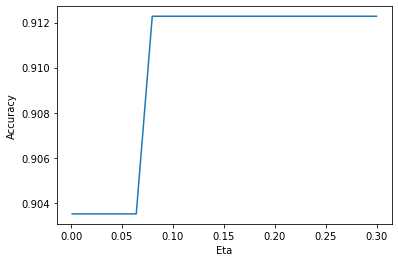

In [3]:
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,test_size=0.2,random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

eta_list = np.linspace(0.001,0.3,20)
acu_scores = np.zeros(len(eta_list))

cntr = 0
for eta in eta_list:
    logreg = NumpyLogReg()
    logreg.fit(X_train = X_train_scaled, t_train = y_train, eta = eta, c= 0.2)#, c = 0.8)
    score = acu_scores[cntr] = logreg.accuracy(X_test_scaled, y_test)
    # print(f"eta: {eta}, score: {score}")
    cntr += 1 
    
    
plt.plot(eta_list, acu_scores)
plt.xlabel("Eta")
plt.ylabel("Accuracy")

In [12]:
from sklearn.linear_model import LogisticRegression

def sci_kit_test_acu(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(penalty="l2", C = 0.2)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    

    return sum(y_pred == y_test) / len(y_pred)

sci_kit_test_acu(X_train_scaled, X_test_scaled, y_train, y_test)



0.9649122807017544